This notebook compares the analytical solution presented in the paper (Analytical Solution for Steady-State Flow in Heterogene-ous Leaky Aquifers: Verification Against MODFLOW 6 by M. Hayek) with the MODFLO 6 solution

In [1]:
import os
import pathlib as pl
import analsol
import flopy
# import git
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

In [2]:
# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwf-leaky"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

In [3]:
# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

In [4]:
# Model units
length_units = "meters"
time_units = "seconds"

In [5]:
# Case1: upgradient constant head H1, Case2: upgradient no-flow
casename = "Case1" 

In [6]:
# Specify downgradient head H2
H2 = 40.0

In [7]:
# Scenario-specific parameters
parameters = {
    "ex-gwf-leaky": {
        "H2": H2,
    }
}

In [8]:
# Model parameters
L = 1000.0
nper = 1  # Number of periods
nlay = 1  # Number of layers
nrow = 1  # Number of rows
ncol = int(L)  # Number of columns
delr = 1.0 # Column width ($m$)
delc = 1.0  # Row width ($m$)
B = 50.0 # Aquifer thicknes ($m$)
b = 1.0 # Aquitard width ($m$)
top = B # Top of the model ($m$)
strt = B  # Starting head ($m$)
icelltype = 0  # Cell conversion type
H1 = 40.0  # Upgradient constant head ($m$), used only in Case1
h0 = 70 # Constant head in the upper aquifer ($m$)
# Bottom
botm = np.zeros((nlay, nrow, ncol), dtype=float)
# Time discretization
tdis_ds = ((1.0, 1, 1.0),)

In [9]:
# Specify heterogeneity (number of zones and values of parameters)
# Here we are using 5 zones with parameters chosen randomly between min and max values
N = 5
ell = [0,100,300,550,700,1000]
min_kf, max_kf = 1e-6, 1e-2
min_kv, max_kv = 1e-9, 1e-7
kf = analsol.generate_log_uniform(min_kf, max_kf, N)
kv = analsol.generate_log_uniform(min_kv, max_kv, N)

delta_ell = []
for i in range(len(kv)):
    delta_ell.append(int(ell[i] / delr))
    
delta_ell = tuple(delta_ell[1:])

In [10]:
# Hydraulic conductivity
array_kf = np.zeros(ncol)
array_kv = np.zeros(ncol)
value_kf = kf[0]
value_kv = kv[0]
ii = 0
for j in range(ncol):
    array_kf[j] = value_kf
    array_kv[j] = value_kv
    if j + 1 in delta_ell:
        value_kf = kf[ii+1]
        value_kv = kv[ii+1]
        ii += 1

In [11]:
# Solver parameters
nouter = 500
ninner = 50
hclose = 1e-9
rclose = 1e-6

Build the MODFLOW 6 model

In [12]:
def build_models(H2=1.0):
    # Constant head cells are specified on the left and right edge of the model
    if casename == "Case1":
        chd_spd = [
            [0, 0, 0, H1],
            [0, 0, ncol - 1, H2],
        ]
    elif casename == "Case2":
        chd_spd = [
            [0, 0, ncol - 1, H2],
        ]
    else:
        raise Exception("case name error not applicable: case name should be Case1 or Case2")

    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6.exe")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        linear_acceleration="bicgstab",
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=f"{rclose} strict",
    )
    gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, newtonoptions="newton")
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=icelltype,
        k=array_kf,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=strt)
    flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chd_spd)
    
    # ghb
    ghb_rec = []
    ghb_stage = h0
    # ghb_cond = kv/bb
    ghb_cond = array_kv/b
    for j in range(1,ncol-1):
        # ghb_rec.append(((0, 0, j), ghb_stage, ghb_cond))
        ghb_rec.append(((0, 0, j), ghb_stage, ghb_cond[j]))
    ghb_spd = {kper:ghb_rec for kper in range(nper)}
    ghb = flopy.mf6.ModflowGwfghb(gwf, stress_period_data=ghb_spd)

    head_filerecord = f"{sim_name}.hds"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        saverecord=[("HEAD", "ALL")],
    )
    return sim

In [13]:
def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)

In [14]:
@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent)
    assert success, buff

In [15]:
# Figure properties
figure_size = (6.3, 2.5)

In [16]:
# Function used to plot hydraulic conductivity and head profiles (analytical vs. MODFLOW 6)
def plot_results(sim, silent=True):
    with styles.USGSMap():
        gwf = sim.get_model(sim_name)
        xedge = gwf.modelgrid.xvertices[0]

        # create MODFLOW 6 head object
        hobj = gwf.output.head()

        # extract heads
        head = hobj.get_data()
        
        
        # fig, ax = plt.subplots(figsize=(6.3, 2.5))
        fig, ax = plt.subplots(2, 1, figsize=(8, 12))
        
        # conductivity
        axx = ax[0]
        x = np.linspace(0,L,1001)[1:]
        axx.semilogy(x, array_kf, label="$k_f$", color="k", lw=2, ls="-", alpha=1.0)
        axx.semilogy(x, array_kv, label="$k_v$", color="b", lw=2, ls="-", alpha=1.0)
        axx.set_xlim(0, L)
        axx.set_ylim(min_kv, max_kf)
        axx.set_xlabel("Horizontal distance, $x$ (m)",fontsize = 18)
        axx.set_ylabel("Hydraulic conductivity, $k_f$, $k_v$ (m/s)",fontsize = 18)
        axx.grid(visible=True, which="both", ls="-")
        axx.legend(frameon=False,loc="center", ncol=2, bbox_to_anchor=(0.5, 0.35), fontsize=18)
        axx.xaxis.set_tick_params(labelsize=11)
        axx.yaxis.set_tick_params(labelsize=11)
        #
        
        # Exact Solution
        axx = ax[1]
        x = []
        h = []
        H = analsol.vector_h_anal(ell, kf, kv, b, B, H1, H2, h0, N, casename=casename)
        for i in range(N):
            x.append(np.linspace(ell[i], ell[i+1], num=10000))
            h.append(analsol.h_heter(x[i], ell[i], ell[i+1], kf[i], kv[i], b, B, h0, H[i], H[i+1]))
            axx.plot(x[i], h[i], "-k", lw=2.0)
        axx.plot(x[i], h[i], "-k", lw=1.0, label="Exact", alpha=1.0)
        axx.text(1000,154.0, "a", weight='bold', fontsize=20)
        
        
        # Numerical (MF6) solution
        axx.plot(xedge[1:], head[0][0], "--b", lw=3.0, label="MODFLOW 6", alpha=1.0)
        for i in range(1,N):
            axx.axvline(x = ell[i], color = 'r', linestyle = "--", lw = 1.0)
        
        axx.set_xlim(0,L)
        axx.set_ylim(0,90)
        axx.set_ylim(20,80)
        axx.set_xlabel("Horizontal distance, $x$ (m)",fontsize = 18)
        axx.set_ylabel("Hydraulic head, $h$ (m)",fontsize = 18)
        axx.grid(visible=True, which="both", ls="-")
        axx.legend(frameon=False, loc="upper center", ncol=2, fontsize=18)
        axx.xaxis.set_tick_params(labelsize=11)
        axx.yaxis.set_tick_params(labelsize=11)
        axx.text(1000,82.0, "b", weight='bold', fontsize=20)

In [17]:
def scenario(silent=True):
    key = list(parameters.keys())[0]
    params = parameters[key].copy()
    sim = build_models(**params)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim, silent=silent)

Run comparison

run_models took 149.36 ms


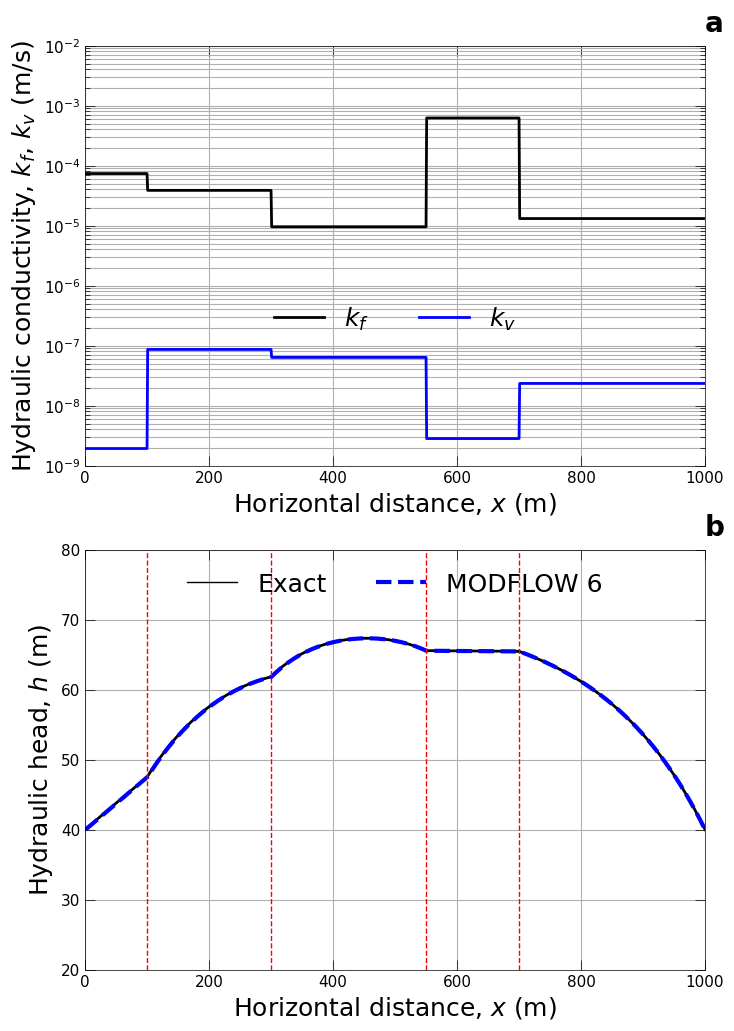

In [18]:
scenario()